In [1]:
# # Setup 
# ! pip install seaborn tqdm_joblib ndlib open-iris==1.0.0

# Imports

In [ ]:
import gc
import random
from functools import partial

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed, parallel_backend
from tqdm.autonotebook import tqdm
from tqdm_joblib import tqdm_joblib
from scipy.ndimage import gaussian_filter, rotate, shift
import networkx as nx
import ndlib.models.opinions as op

In [ ]:
from iris.io.dataclasses import IrisTemplate

# Constants

In [4]:
n_jobs = 6 # Fit to CPU
DIM = (2, 32, 200)
X, Y = DIM [1:]

In [5]:
methods_conf_dict = {
    'gaussian':{
        'low':{'num_clusters':55, 'min_cluster_size':90, 'max_cluster_size':100},
        'high':{'num_clusters':80, 'min_cluster_size':20, 'max_cluster_size':30},
    },
    'voter':{
        'low':{'iterations':80000},
        'high':{'iterations':7000},
    },
    'voter_gaussian':{
        'low':{'iterations':80000, 'num_clusters':120, 'min_cluster_size':50, 'max_cluster_size':100},
        'high':{'iterations':7000, 'num_clusters':180, 'min_cluster_size':5, 'max_cluster_size':50},
    },
    'bryan_voter':{
        'low':{'path':'2M_voter_arrays_80k_b45.dat', 'total_num_samples':1000000},
        'high':{'path':'2M_voter_arrays_7k_b13.dat', 'total_num_samples':1000000},
    },
}

# Functions

## Gaussian based

In [6]:
def generate_gaussian_blob(X, Y, size):
    # Generate blob
    blob = np.zeros((X, Y), dtype=float)
    blob[X//2, Y//2] = 1
    sigma_x = np.sqrt(size) / np.clip(np.random.normal(loc=5, scale=2), 1, 5)
    sigma_y = np.sqrt(size) / np.clip(np.random.normal(loc=15, scale=2), 10, 20)
    blob = gaussian_filter(blob, sigma=[sigma_x, sigma_y])
    
    # Rotate blob
    angle = np.clip(np.random.normal(loc=0, scale=30), -90, 90)
    blob = rotate(blob, angle, reshape=False)
    blob = blob > blob.mean()
    
    # Random shift of the blob
    x_shift = np.random.randint(0, X) - X//2
    y_shift = np.random.randint(0, Y) - Y//2
    blob_final = shift(blob, shift=[x_shift, y_shift])
    return blob_final.astype(np.bool_)

def generate_gaussian_matrix(X, Y, num_clusters, min_cluster_size, max_cluster_size):
    cluster_sizes = np.clip(
        np.random.normal(
            loc=(min_cluster_size + max_cluster_size) / 2, 
            scale=(max_cluster_size - min_cluster_size) / 6, 
            size=num_clusters), 
        min_cluster_size, max_cluster_size
    )
    with parallel_backend('threading', verbose=0):
        blobs = Parallel(n_jobs=n_jobs)(
            delayed(generate_gaussian_blob)(X, Y, size) for size in cluster_sizes
        )
    return ~np.logical_or.reduce(blobs, dtype=np.bool_)

## Voter model based

In [7]:
class DoublePollingVoterModel:
    def __init__(self, graph):
        self.graph = graph

    def iteration(self):
        # Randomly select a node
        node = random.choice(list(self.graph.nodes))
        
        # Randomly select two neighbors
        neighbors = random.sample(list(self.graph.neighbors(node)), 2)
        
        # Get their opinions
        opinion_1, opinion_2 = self.status[neighbors[0]], self.status[neighbors[1]]
        
        # Apply majority rule: if opinions are the same, adopt that opinion; otherwise, randomly choose one
        new_opinion = opinion_1 if opinion_1 == opinion_2 else random.choice([opinion_1, opinion_2])
        
        # Update the selected node's opinion
        self.status[node] = new_opinion

        return self.status

    def iteration_bunch(self, iterations):
        for _ in range(iterations):
            self.iteration()
        return self.status

In [8]:
def get_gaussian_based_initial_opinions(X, Y, num_clusters, min_cluster_size, max_cluster_size, G):
    gaussian_matrix = generate_gaussian_matrix(X, Y, num_clusters, min_cluster_size, max_cluster_size)
    return {node: int(opinion) for node, opinion in zip(G.nodes(), gaussian_matrix.flat)}

In [9]:
def generate_voter_model_matrix(X, Y, iterations, DoublePolling=True, GaussianOpinions=False, 
                                num_clusters=120, min_cluster_size=1, max_cluster_size=100):
    G = nx.grid_2d_graph(X, Y)
    voter_model = DoublePollingVoterModel(G) if DoublePolling else op.VoterModel(G)
    initial_opinions = (
        get_gaussian_based_initial_opinions(X, Y, num_clusters, min_cluster_size, max_cluster_size, G)
        if GaussianOpinions else {node: np.random.choice([0, 1]) for node in G.nodes()}
    )
    voter_model.status = initial_opinions
    voter_model.iteration_bunch(iterations) # Check for preferring vertical movements
    final_opinions = np.array([voter_model.status[node] for node in G.nodes()], dtype=np.bool_).reshape(X, Y)
    return final_opinions

## Bryan based voter model

In [10]:
def import_voter_model_rust_implementation(path, total_num_samples, num_samples=None, DIM=DIM):
    num_samples = num_samples if num_samples else total_num_samples
    assert num_samples <= total_num_samples
    data = np.fromfile(path, dtype=np.uint8)
    return (
        np.unpackbits(data, bitorder="little")
        .reshape(total_num_samples, *DIM[1:])
        [np.random.choice(total_num_samples, size=num_samples, replace=False)]
    )

In [11]:
def generate_bryan_voter_model_matrix(path, total_num_samples):
    wavelength = 'low' if methods_conf_dict['bryan_voter']['low']['path'] == path else 'high'
    dataset_attr = f'{wavelength}_wavelength_dataset'
    counter_attr = f'{wavelength}_counter'
    
    # Check if the dataset is already loaded
    if not hasattr(generate_bryan_voter_model_matrix, dataset_attr):
        setattr(generate_bryan_voter_model_matrix, dataset_attr, import_voter_model_rust_implementation(path, total_num_samples))
        setattr(generate_bryan_voter_model_matrix, counter_attr, 0)

    # Get the current matrix and increment the counter
    dataset = getattr(generate_bryan_voter_model_matrix, dataset_attr)
    counter = getattr(generate_bryan_voter_model_matrix, counter_attr)
    matrix = dataset[counter]
    
    # Update the counter
    setattr(generate_bryan_voter_model_matrix, counter_attr, counter + 1)
    return matrix

## Image plotting

In [12]:
def plot_boolean_iris(matrix, title=''):
    plt.imshow(matrix, cmap='gray')
    plt.title(title)
    plt.show()

In [17]:
voter_model_iris = generate_voter_model_matrix(X, Y, DoublePolling=False, **methods_conf_dict['voter']['low'])

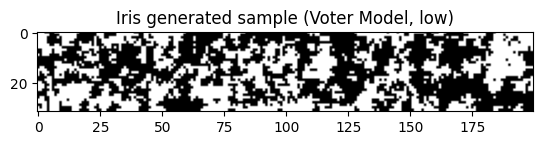

In [18]:
plot_boolean_iris(voter_model_iris, title='Iris generated sample (Voter Model, low)')

In [19]:
voter_model_iris = generate_voter_model_matrix(X, Y, **methods_conf_dict['voter']['low'])

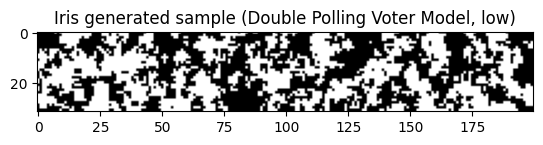

In [20]:
plot_boolean_iris(voter_model_iris, title='Iris generated sample (Double Polling Voter Model, low)')

In [31]:
gaussian_iris = generate_gaussian_matrix(X, Y, **methods_conf_dict['gaussian']['low'])

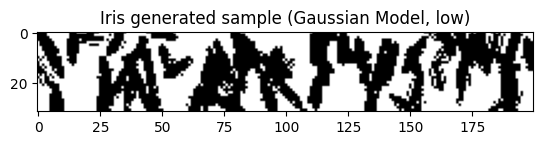

In [61]:
plot_boolean_iris(gaussian_iris, title='Iris generated sample (Gaussian Model, low)')

In [33]:
voter_model_iris = generate_voter_model_matrix(X, Y, GaussianOpinions=True, **methods_conf_dict['voter_gaussian']['low'])

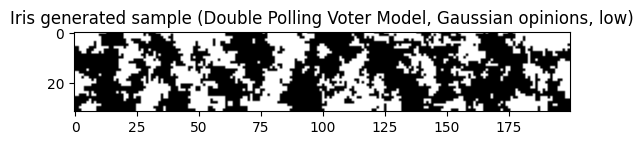

In [34]:
plot_boolean_iris(voter_model_iris, title='Iris generated sample (Double Polling Voter Model, Gaussian opinions, low)')

In [13]:
data = import_voter_model_rust_implementation('2M_voter_arrays_80k_b45.dat', 1000000, 1)

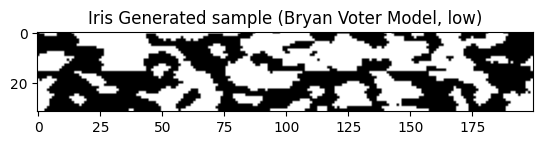

In [14]:
plot_boolean_iris(data[0], title='Iris Generated sample (Bryan Voter Model, low)')

## Iris wrapping implementation

In [96]:
method_to_func_dict = {
    'gaussian':{'func':generate_gaussian_matrix, 'args':{'X': X, 'Y': Y}},
    'voter':{'func':generate_voter_model_matrix, 'args':{'X': X, 'Y': Y}},
    'voter_gaussian':{'func':generate_voter_model_matrix, 'args':{'X': X, 'Y': Y, 'GaussianOpinions': True}},
    'bryan_voter':{'func':generate_bryan_voter_model_matrix, 'args':{}},
}

In [97]:
def create_iris_template(matrix, DIM=DIM):
    return IrisTemplate(
        iris_codes=matrix,
        mask_codes=[np.ones(DIM[1:], dtype=np.bool_) for _ in range(DIM[0])], # No mask
        # iris_code_version="v3.0" # Iris version 1.0.0 doesn't work here
    )

In [98]:
def wavelength_wrapper(method):
    method_args = method_to_func_dict[method]['args']
    both_wavelengths = [
        method_to_func_dict[method]['func'](**method_args, **methods_conf_dict[method][wavelength]) for wavelength in ['low', 'high']
    ]
    return np.concatenate(both_wavelengths)

In [108]:
for method in method_to_func_dict.keys():
    matrix = wavelength_wrapper(method)
    plot_boolean_iris(matrix, title=method)

In [25]:
def generate_and_save_synthetic_data(method, num_samples, path='compressed_iris_matrices'):
    with tqdm_joblib(tqdm(desc="Generating matrices", total=num_samples)) as progress_bar:
        matrices = Parallel(n_jobs=n_jobs)(delayed(wavelength_wrapper)(method) for _ in range(num_samples))
    combined_array = np.stack(matrices, axis=0)
    np.savez_compressed(f'{path}_{method}.npz', data=combined_array)

In [26]:
# for method in ['gaussian', 'voter', 'voter_gaussian']:
#     generate_and_save_synthetic_data(method, num_samples=1000)

Generating matrices:   0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Generating matrices:   0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
def load_synthetic_iris(method, num_samples, path='compressed_iris_matrices'):
    # Load data and randomly select num_samples samples
    loaded_data = np.load(f'{path}_{method}.npz')['data']
    assert loaded_data.shape[0] >= num_samples, f"Requested {num_samples} samples, but only {loaded_data.shape[0]} available."
    indices = np.random.choice(loaded_data.shape[0], num_samples, replace=False)

    # Use Parallel to create IrisTemplate objects in parallel
    iris_templates = Parallel(n_jobs=n_jobs)(delayed(create_iris_template)(list(matrix)) for matrix in loaded_data[indices])
    return pd.DataFrame({'Template': iris_templates}).assign(ID = np.nan)

In [452]:
# generated_data = load_synthetic_iris(path_suffix='gaussian', num_samples=2000)